Download the Dataset using Kaggle API

In [2]:
!kaggle datasets download phucthaiv02/butterfly-image-classification

Dataset URL: https://www.kaggle.com/datasets/phucthaiv02/butterfly-image-classification
License(s): CC0-1.0
 98%|███████████████████████████████████████▏| 221M/226M [00:06<00:00, 36.7MB/s]
100%|████████████████████████████████████████| 226M/226M [00:06<00:00, 35.4MB/s]


In [3]:
!unzip butterfly-image-classification.zip

Archive:  butterfly-image-classification.zip
  inflating: Testing_set.csv         
  inflating: Training_set.csv        
  inflating: test/Image_1.jpg        
  inflating: test/Image_10.jpg       
  inflating: test/Image_100.jpg      
  inflating: test/Image_1000.jpg     
  inflating: test/Image_1001.jpg     
  inflating: test/Image_1002.jpg     
  inflating: test/Image_1003.jpg     
  inflating: test/Image_1004.jpg     
  inflating: test/Image_1005.jpg     
  inflating: test/Image_1006.jpg     
  inflating: test/Image_1007.jpg     
  inflating: test/Image_1008.jpg     
  inflating: test/Image_1009.jpg     
  inflating: test/Image_101.jpg      
  inflating: test/Image_1010.jpg     
  inflating: test/Image_1011.jpg     
  inflating: test/Image_1012.jpg     
  inflating: test/Image_1013.jpg     
  inflating: test/Image_1014.jpg     
  inflating: test/Image_1015.jpg     
  inflating: test/Image_1016.jpg     
  inflating: test/Image_1017.jpg     
  inflating: test/Image_1018.jpg     
  inf

 Imports and Dataset Preparation

In [4]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf

2024-10-22 23:24:09.588822: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-22 23:24:10.034253: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-22 23:24:12.982809: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-22 23:24:12.994862: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-22 23:24:17.711836: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [13]:
# Updated paths for CSV files and images
train_csv_path = 'Training_set.csv'
test_csv_path = 'Testing_set.csv'
train_images_dir = 'train/'
test_images_dir = 'test/'

In [14]:

train_df = pd.read_csv(train_csv_path)
test_df = pd.read_csv(test_csv_path)

In [15]:
# Preview the data
print(train_df.head())
print(test_df.head())

      filename                     label
0  Image_1.jpg          SOUTHERN DOGFACE
1  Image_2.jpg                    ADONIS
2  Image_3.jpg            BROWN SIPROETA
3  Image_4.jpg                   MONARCH
4  Image_5.jpg  GREEN CELLED CATTLEHEART
      filename
0  Image_1.jpg
1  Image_2.jpg
2  Image_3.jpg
3  Image_4.jpg
4  Image_5.jpg


In [17]:
# Inspect the column names in the training dataframe
print(train_df.columns)

Index(['filename', 'label'], dtype='object')


Data Preprocessing

In [19]:
# Image size and batch size
img_size = (128, 128)
batch_size = 32

# Data augmentation for training set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # 20% for validation
)

# Data generator for test set (without augmentation)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load images and split data for training/validation
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    directory=train_images_dir,
    x_col='filename',
    y_col='label',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_dataframe(
    train_df,
    directory=train_images_dir,
    x_col='filename',
    y_col='label',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

# Test data generator
test_generator = test_datagen.flow_from_dataframe(
    test_df,
    directory=test_images_dir,
    x_col='filename',
    target_size=img_size,
    batch_size=1,
    class_mode=None,  # No labels in the test set
    shuffle=False
)


Found 5200 validated image filenames belonging to 75 classes.


Found 1299 validated image filenames belonging to 75 classes.
Found 2786 validated image filenames.


Building the CNN Model

In [20]:
# Build CNN model
model = Sequential()

# 1st Convolutional Block
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

# 2nd Convolutional Block
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# 3rd Convolutional Block
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Fully Connected Layers
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(75, activation='softmax'))  # 75 classes for butterfly species

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 128)       0

Training the Model

In [21]:
# Train the model
epochs = 25

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=epochs
)


Epoch 1/25
162/162 [==============================] - 37s 220ms/step - loss: 4.0698 - accuracy: 0.0402 - val_loss: 3.5866 - val_accuracy: 0.0945
Epoch 2/25
162/162 [==============================] - 36s 220ms/step - loss: 3.4238 - accuracy: 0.1281 - val_loss: 3.0067 - val_accuracy: 0.2023
Epoch 3/25
162/162 [==============================] - 35s 217ms/step - loss: 2.9871 - accuracy: 0.2144 - val_loss: 2.6305 - val_accuracy: 0.3063
Epoch 4/25
162/162 [==============================] - 35s 218ms/step - loss: 2.6078 - accuracy: 0.2908 - val_loss: 2.2021 - val_accuracy: 0.3781
Epoch 5/25
162/162 [==============================] - 36s 220ms/step - loss: 2.3651 - accuracy: 0.3452 - val_loss: 2.0184 - val_accuracy: 0.4414
Epoch 6/25
162/162 [==============================] - 36s 219ms/step - loss: 2.2003 - accuracy: 0.3864 - val_loss: 1.9420 - val_accuracy: 0.4586
Epoch 7/25
162/162 [==============================] - 36s 219ms/step - loss: 2.0347 - accuracy: 0.4226 - val_loss: 1.8346 - val_ac

Evaluating the Model

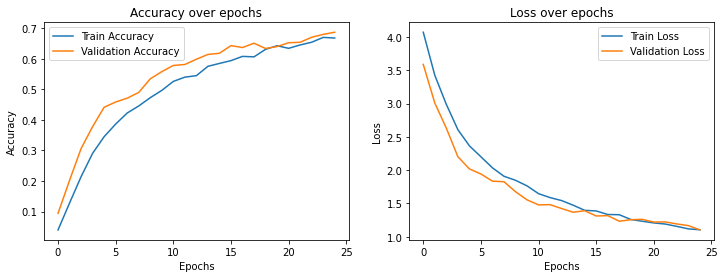

41/41 [==============================] - 6s 146ms/step
[[0 1 0 ... 0 0 0]
 [1 0 0 ... 0 1 0]
 [0 1 0 ... 0 0 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
                           precision    recall  f1-score   support

                   ADONIS       0.00      0.00      0.00        19
AFRICAN GIANT SWALLOWTAIL       0.00      0.00      0.00        17
           AMERICAN SNOOT       0.00      0.00      0.00        16
                    AN 88       0.00      0.00      0.00        17
                  APPOLLO       0.00      0.00      0.00        14
                    ATALA       0.00      0.00      0.00        23
 BANDED ORANGE HELICONIAN       0.06      0.05      0.05        19
           BANDED PEACOCK       0.07      0.06      0.06        16
            BECKERS WHITE       0.00      0.00      0.00        16
         BLACK HAIRSTREAK       0.00      0.00      0.00        27
              BLUE MORPHO       0.08      0.10      0.09        10
        BLUE SPOTTED

In [22]:
# Plot training & validation accuracy/loss
plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Confusion matrix and classification report
val_generator = validation_generator
val_generator.reset()

val_predictions = np.argmax(model.predict(val_generator), axis=-1)
val_true = val_generator.classes
class_labels = list(val_generator.class_indices.keys())

print(confusion_matrix(val_true, val_predictions))
print(classification_report(val_true, val_predictions, target_names=class_labels))


 Making Predictions on the Test Set


In [23]:
# Predict on test set
test_generator.reset()
predictions = np.argmax(model.predict(test_generator), axis=-1)

# Map class indices to labels
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predictions]

# Add predictions to the test dataframe and save
test_df['label'] = predictions
test_df.to_csv('submission.csv', index=False)

print("Predictions saved to submission.csv")


2786/2786 [==============================] - 11s 4ms/step
Predictions saved to submission.csv
